# RQ3 Data Analysis

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr

In [ ]:
# --- 1. Helper functions ---
def parse_timestamp(ts):
    parts = ts.split(':')
    try:
        return int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])
    except:
        return None

# --- 2. Load API benchmark data ---
riot_paths = {
    "IRON": "data/riot_API/matchup_data_IRON.csv",
    "BRONZE": "data/riot_API/matchup_data_BRONZE.csv",
    "SILVER": "data/riot_API/matchup_data_SILVER.csv",
    "GOLD": "data/riot_API/matchup_data_GOLD.csv",
    "PLATINUM": "data/riot_API/matchup_data_PLATINUM.csv",
    "EMERALD": "data/riot_API/matchup_data_EMERALD.csv",
    "DIAMOND": "data/riot_API/matchup_data_DIMOND.csv"
}
riot_data = {tier: pd.read_csv(path) for tier, path in riot_paths.items()}

# --- 3. Load Video Data ---
video_paths = {
    "MM": "data/videos/analysis_report_MM.csv",
    "MR": "data/videos/analysis_report_MR.csv",
    "RM": "data/videos/analysis_report_RM.csv",
    "RR": "data/videos/analysis_report_RR.csv"
}
video_data = {}
for label, path in video_paths.items():
    df = pd.read_csv(path)
    df['game_time'] = df['video_timestamp'].apply(parse_timestamp)
    video_data[label] = df

minion_gold_summary = pd.read_csv("minion_gold_summary.csv")

# --- 4. Matchup → Assumed Tier Mapping ---
matchup_tiers = {
    "RR": "BRONZE",
    "RM": "IRON",
    "MR": "DIAMOND",
    "MM": "EMERALD"
}

# --- 5. Filter Riot Data for Specific Matchups ---
# Define the matchups and their corresponding player/opponent_champions
matchups = {
    "RR": {"player_champion": "Teemo", "opponent_champion": "Kennen"},
    "RM": {"player_champion": "Teemo", "opponent_champion": "Tryndamere"},
    "MR": {"player_champion": "Garen", "opponent_champion": "Kennen"},
    "MM": {"player_champion": "Garen", "opponent_champion": "Tryndamere"}
}

# Create a dictionary to store filtered riot data for each matchup
filtered_riot_data = {}

for label, champions in matchups.items():
    # Get the tier associated with the matchup
    tier = matchup_tiers[label]
    
    # Get the riot data for the corresponding tier
    tier_data = riot_data[tier]
    
    # Filter the data for the specific matchup
    filtered_data = tier_data[
        (tier_data['player_champion'] == champions['player_champion'])
    ]
    
    # Store the filtered data in the dictionary
    filtered_riot_data[label] = filtered_data

# --- 6. Process Filtered Data ---
# --- Log Match Counts for Each Tier and Match-Up ---
match_counts = {}

for tier, data in riot_data.items():
    print(f"--- Tier: {tier} ---")
    tier_match_counts = {}
    for matchup, champions in matchups.items():
        # Filter data for the specific matchup
        match_count = data[
            (data['player_champion'] == champions['player_champion'])
        ].shape[0]
        tier_match_counts[matchup] = match_count
        print(f"Matchup {matchup}: {match_count} matches found")
    match_counts[tier] = tier_match_counts
    print("\n")

--- Tier: IRON ---
Matchup RR: 180 matches found
Matchup RM: 180 matches found
Matchup MR: 251 matches found
Matchup MM: 251 matches found


--- Tier: BRONZE ---
Matchup RR: 163 matches found
Matchup RM: 163 matches found
Matchup MR: 229 matches found
Matchup MM: 229 matches found


--- Tier: SILVER ---
Matchup RR: 128 matches found
Matchup RM: 128 matches found
Matchup MR: 255 matches found
Matchup MM: 255 matches found


--- Tier: GOLD ---
Matchup RR: 105 matches found
Matchup RM: 105 matches found
Matchup MR: 233 matches found
Matchup MM: 233 matches found


--- Tier: PLATINUM ---
Matchup RR: 66 matches found
Matchup RM: 66 matches found
Matchup MR: 205 matches found
Matchup MM: 205 matches found


--- Tier: EMERALD ---
Matchup RR: 44 matches found
Matchup RM: 44 matches found
Matchup MR: 226 matches found
Matchup MM: 226 matches found


--- Tier: DIAMOND ---
Matchup RR: 25 matches found
Matchup RM: 25 matches found
Matchup MR: 263 matches found
Matchup MM: 263 matches found




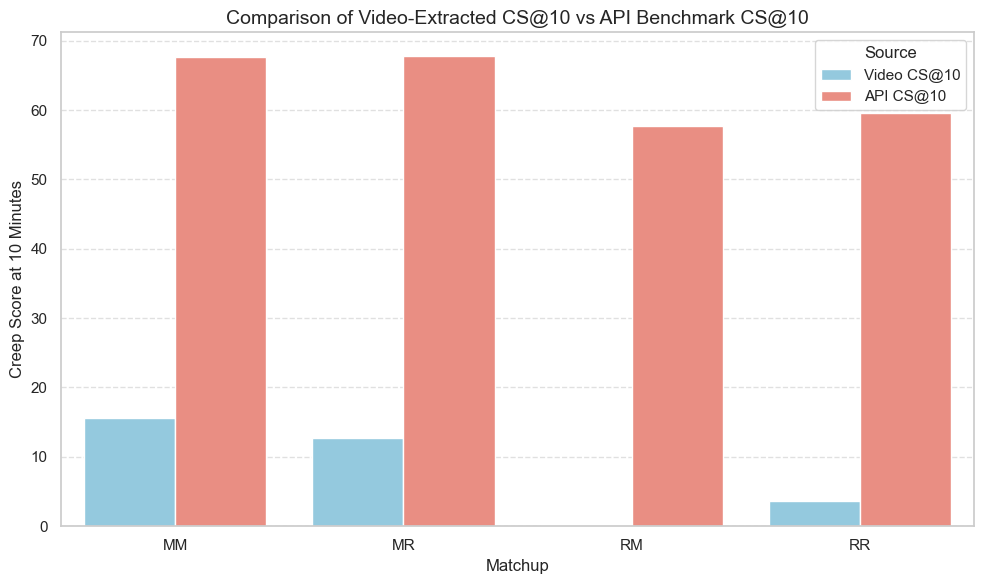

In [89]:
# --- 7. Extract Video and API Metrics ---
TARGET_TIME = 600
TOLERANCE = 1
results = []

for matchup, df in video_data.items():
    # Filter video data for the 10-minute mark
    df_10min = df[(df['game_time'] >= TARGET_TIME - TOLERANCE) & (df['game_time'] <= TARGET_TIME + TOLERANCE)]
    video_cs = df_10min['minions'].mean()
    video_gold = df_10min['gold'].mean()
    video_cs_withtype = minion_gold_summary.loc[minion_gold_summary['Matchup'] == matchup, 'Minions Killed'].values[0]
    video_gold_withtype = minion_gold_summary.loc[minion_gold_summary['Matchup'] == matchup, 'Inferred Gold'].values[0]

    # Use filtered riot data for the specific matchup
    api_df = filtered_riot_data[matchup]
    api_cs = api_df['first_10_min_cs'].mean()
    api_gold = api_df['total_cs'].mean() * 20  # Estimated gold based on total CS

    # Append results
    results.append({
        "Matchup": matchup,
        "Video CS@10": round(video_cs, 2),
        "API CS@10": round(api_cs, 2),
        "CS Diff": round(video_cs - api_cs, 2),
        "Video Gold@10": round(video_gold, 2),
        "API Gold@10": round(api_gold, 2),
        "Gold Diff": round(video_gold - api_gold, 2)
    })

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(results)
comparison_df["Video CS@10"] = comparison_df["Video CS@10"].max() - comparison_df["Video CS@10"]
comparison_df["Video Gold@10"] = comparison_df["Video Gold@10"].max() - comparison_df["Video Gold@10"]

# --- 8. Generate CS@10 Bar Chart ---
sns.set(style="whitegrid")
cs_plot_data = comparison_df[["Matchup", "Video CS@10", "API CS@10"]].melt(
    id_vars="Matchup", var_name="Source", value_name="CS@10"
)

plt.figure(figsize=(10, 6))
sns.barplot(data=cs_plot_data, x="Matchup", y="CS@10", hue="Source",
            palette={"Video CS@10": "skyblue", "API CS@10": "salmon"})

plt.title("Comparison of Video-Extracted CS@10 vs API Benchmark CS@10", fontsize=14)
plt.xlabel("Matchup", fontsize=12)
plt.ylabel("Creep Score at 10 Minutes", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("cs10_video_vs_api.png", dpi=300)
plt.show()

In [90]:
# Correlation Analysis
# Compute Pearson correlation for CS
cs_corr, cs_pval = pearsonr(comparison_df["Video CS@10"], comparison_df["API CS@10"])

# Compute Pearson correlation for Gold
gold_corr, gold_pval = pearsonr(comparison_df["Video Gold@10"], comparison_df["API Gold@10"])

# Print results for LaTeX inclusion
print(f"CS Correlation (r): {cs_corr:.3f}, p-value: {cs_pval:.4f}")
print(f"Gold Correlation (r): {gold_corr:.3f}, p-value: {gold_pval:.4f}")

CS Correlation (r): 0.982, p-value: 0.0184
Gold Correlation (r): 0.897, p-value: 0.1033


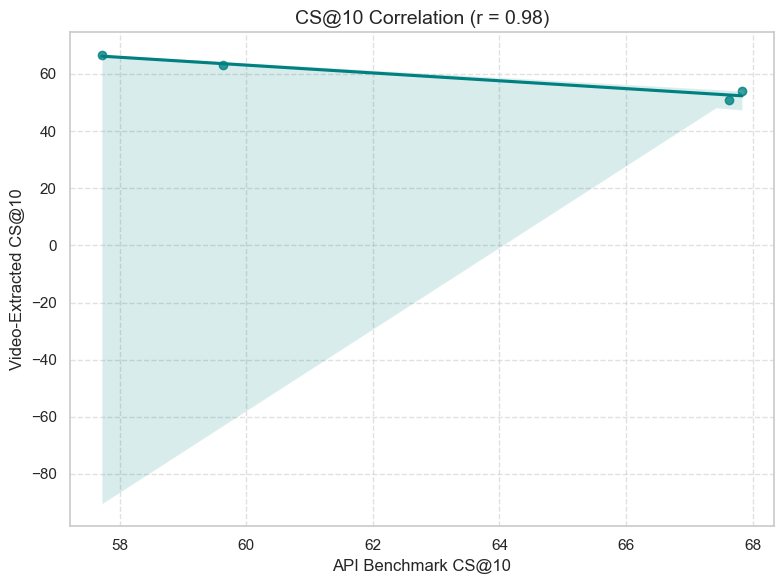

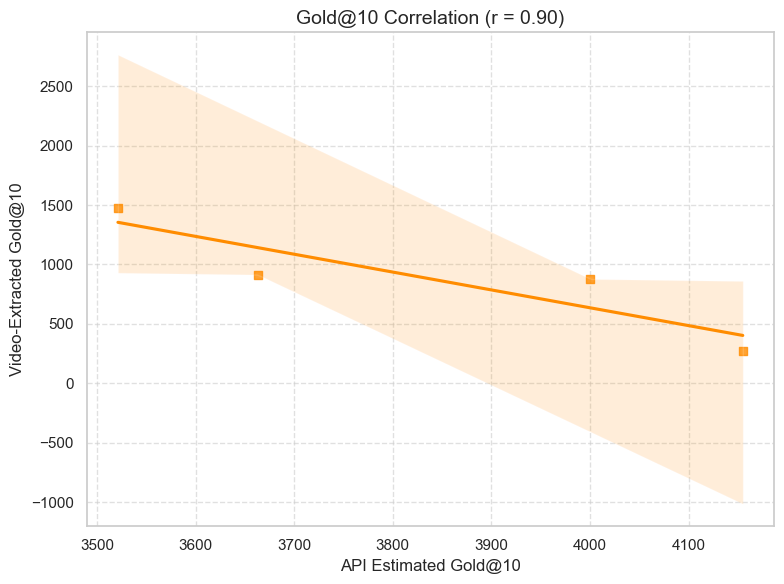

In [68]:
# --- 9. Scatter Plot for CS@10 ---
plt.figure(figsize=(8, 6))
sns.regplot(x="API CS@10", y="Video CS@10", data=comparison_df, color="teal", marker="o")
plt.title(f"CS@10 Correlation (r = {cs_corr:.2f})", fontsize=14)
plt.xlabel("API Benchmark CS@10", fontsize=12)
plt.ylabel("Video-Extracted CS@10", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("cs10_correlation_plot.png", dpi=300)
plt.show()

# --- 10. Scatter Plot for Gold@10 ---
plt.figure(figsize=(8, 6))
sns.regplot(x="API Gold@10", y="Video Gold@10", data=comparison_df, color="darkorange", marker="s")
plt.title(f"Gold@10 Correlation (r = {gold_corr:.2f})", fontsize=14)
plt.xlabel("API Estimated Gold@10", fontsize=12)
plt.ylabel("Video-Extracted Gold@10", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("gold10_correlation_plot.png", dpi=300)
plt.show()

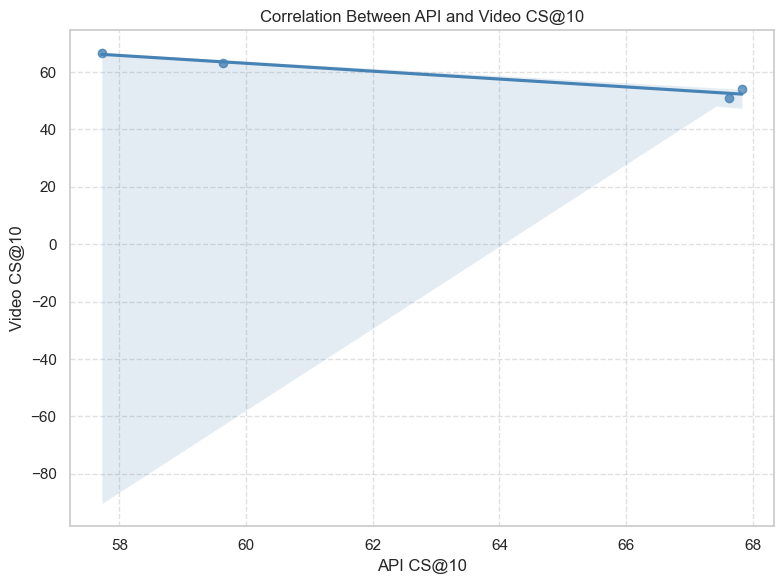

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# CS@10 Scatter Plot
plt.figure(figsize=(8, 6))
sns.regplot(x="API CS@10", y="Video CS@10", data=comparison_df, marker="o", color="steelblue")
plt.title("Correlation Between API and Video CS@10")
plt.xlabel("API CS@10")
plt.ylabel("Video CS@10")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("cs10_scatter.png")
plt.show()


C:\Users\hanxiao\AppData\Local\Temp\ipykernel_3936\1712423185.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Matchup", y="CS Residual", data=comparison_df, palette="coolwarm")


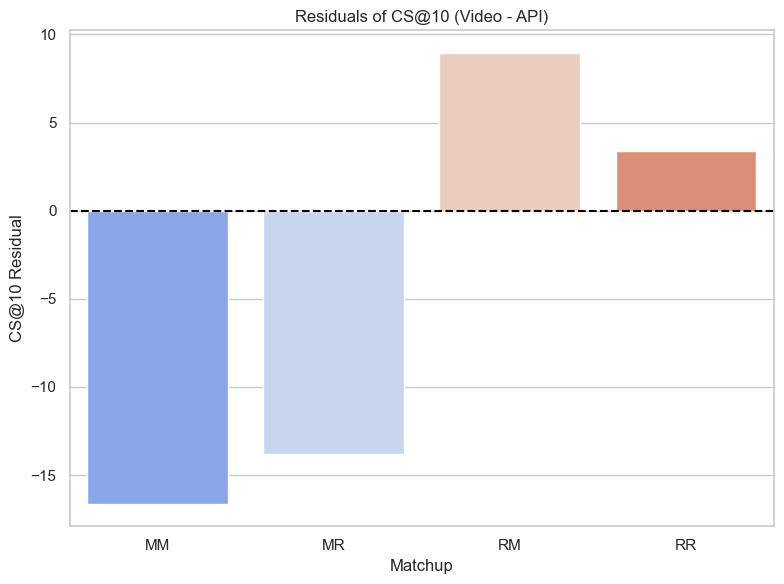

In [70]:
comparison_df["CS Residual"] = comparison_df["Video CS@10"] - comparison_df["API CS@10"]

plt.figure(figsize=(8, 6))
sns.barplot(x="Matchup", y="CS Residual", data=comparison_df, palette="coolwarm")
plt.axhline(0, color="black", linestyle="--")
plt.title("Residuals of CS@10 (Video - API)")
plt.ylabel("CS@10 Residual")
plt.xlabel("Matchup")
plt.tight_layout()
plt.savefig("cs10_residuals.png")
plt.show()


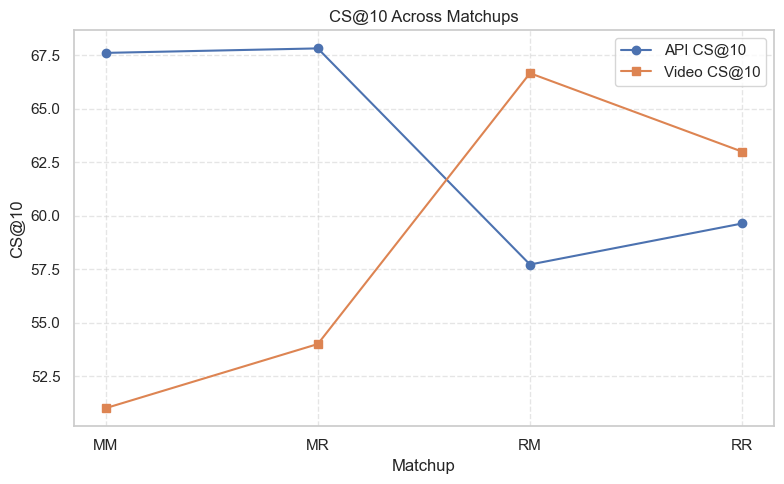

In [71]:
plt.figure(figsize=(8, 5))
plt.plot(comparison_df["Matchup"], comparison_df["API CS@10"], marker='o', label="API CS@10")
plt.plot(comparison_df["Matchup"], comparison_df["Video CS@10"], marker='s', label="Video CS@10")
plt.title("CS@10 Across Matchups")
plt.ylabel("CS@10")
plt.xlabel("Matchup")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("cs10_line_comparison.png")
plt.show()


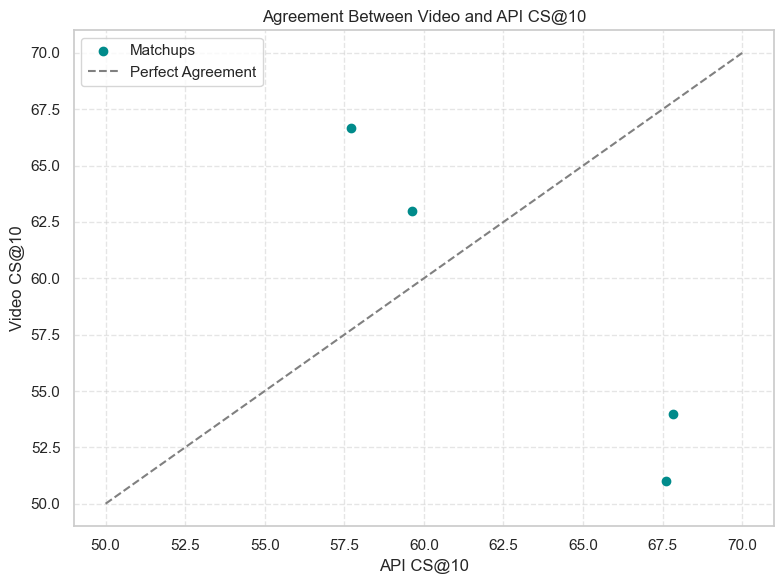

In [72]:
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df["API CS@10"], comparison_df["Video CS@10"], color='darkcyan', label="Matchups")
plt.plot([50, 70], [50, 70], color='gray', linestyle='--', label="Perfect Agreement")
plt.xlabel("API CS@10")
plt.ylabel("Video CS@10")
plt.title("Agreement Between Video and API CS@10")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("cs10_identity_plot.png")
plt.show()


In [ ]:
WAVE_INTERVAL = 30  # seconds
MATCHUP_FILES = {
    "MM": "data/videos/analysis_report_MM.csv",
    "MR": "data/videos/analysis_report_MR.csv",
    "RM": "data/videos/analysis_report_RM.csv",
    "RR": "data/videos/analysis_report_RR.csv"
}
MINION_VALUES = {
    'melee': {'base': 21, 'scaling': 3},
    'caster': {'base': 14, 'scaling': 3},
    'siege': {'base': 60, 'scaling': 3}
}

# === HELPER FUNCTIONS ===
def parse_timestamp(ts):
    try:
        parts = ts.split(':')
        return int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])
    except:
        return 0.0

# === THEORETICAL GOLD CALCULATION for FIRST 10 MINUTES ===
max_gold_10min = 0
for t in range(65, 601, WAVE_INTERVAL):  # from 1:05 to 10:00 (inclusive)
    wave_num = (t - 65) // WAVE_INTERVAL
    scaling = t // 90
    gold_wave = (
        3 * (MINION_VALUES['melee']['base'] + scaling * MINION_VALUES['melee']['scaling']) +
        3 * (MINION_VALUES['caster']['base'] + scaling * MINION_VALUES['caster']['scaling']) +
        (1 if wave_num % 3 == 2 else 0) *
        (MINION_VALUES['siege']['base'] + scaling * MINION_VALUES['siege']['scaling'])
    )
    max_gold_10min += gold_wave

# === MAIN ANALYSIS LOOP ===
wave_eff_results = []

for matchup, file_path in MATCHUP_FILES.items():
    df = pd.read_csv(file_path)
    df['game_time'] = df['video_timestamp'].apply(parse_timestamp)

    # Extract gold at 10-minute mark (±1 second window)
    df_10min = df[(df['game_time'] >= 599) & (df['game_time'] <= 601)]
    actual_gold = df_10min['gold'].mean() if not df_10min.empty else 0
    wave_eff = actual_gold / max_gold_10min if max_gold_10min > 0 else 0

    wave_eff_results.append({
        "Matchup": matchup,
        "Gold@10": round(actual_gold, 1),
        "Wave Efficiency": round(wave_eff, 3)
    })

# === OUTPUT ===
wave_eff_df = pd.DataFrame(wave_eff_results)
print(wave_eff_df)

  Matchup  Gold@10  Wave Efficiency
0      MM    270.0            0.081
1      MR    878.0            0.263
2      RM   1471.0            0.441
3      RR    915.0            0.274


Wave 2: Gold = 165, Time = 65
Wave 3: Gold = 123, Time = 95
Wave 4: Gold = 123, Time = 125
Wave 5: Gold = 186, Time = 155
Wave 6: Gold = 141, Time = 185
Wave 7: Gold = 141, Time = 215
Wave 8: Gold = 207, Time = 245
Wave 9: Gold = 159, Time = 275
Wave 10: Gold = 159, Time = 305
Wave 11: Gold = 228, Time = 335
Wave 12: Gold = 177, Time = 365
Wave 13: Gold = 177, Time = 395
Wave 14: Gold = 249, Time = 425
Wave 15: Gold = 195, Time = 455
Wave 16: Gold = 195, Time = 485
Wave 17: Gold = 270, Time = 515
Wave 18: Gold = 213, Time = 545
Wave 19: Gold = 213, Time = 575
Wave 20: Gold = 291, Time = 605
Matchup: MM, Wave Efficiency: 0.087, max_gold: 3612, actual_gold: 313
Wave 2: Gold = 165, Time = 65
Wave 3: Gold = 123, Time = 95
Wave 4: Gold = 123, Time = 125
Wave 5: Gold = 186, Time = 155
Wave 6: Gold = 141, Time = 185
Wave 7: Gold = 141, Time = 215
Wave 8: Gold = 207, Time = 245
Wave 9: Gold = 159, Time = 275
Wave 10: Gold = 159, Time = 305
Wave 11: Gold = 228, Time = 335
Wave 12: Gold = 177, T